In [1]:
import gc
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
gc.enable()

# 3章 word2vec

## 推論ベースの手法とニューラルネットワーク

### カウントベースの手法の問題点

### 推論ベースの手法の概要

### ニューラルネットワークにおける単語の処理方法

In [3]:
from common.layers import MatMul

In [4]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
h

array([[ 0.4448807 , -0.58547683, -0.93553739]])

## シンプルなword2vec

### CBOWモデルの推論処理

In [6]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

In [7]:
# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

In [8]:
# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

In [9]:
# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
s

array([[ 0.05606128,  1.92373019, -4.63564149, -1.67415887, -1.90592774,
        -0.05539819, -2.33903101]])

### CBOWモデルの学習

### word2vecの重みと分散表現

## 学習データの準備

In [10]:
from common.util import preprocess

In [11]:
text = 'You say goodbye and I say hello.'

In [12]:
corpus, word_to_id, id_to_word = preprocess(text)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [14]:
from common.util import create_contexts_target

In [15]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [16]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [17]:
target

array([1, 2, 3, 4, 1, 5])

In [18]:
from common.util import convert_one_hot

In [21]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## CBOWモデルの実装

In [23]:
from common.layers import MatMul, SoftmaxWithLoss

In [30]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # すべての重みと購買をリストにまとめる
        layers = [self.in_layer0,
                  self.in_layer1,
                  self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [31]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import (preprocess,
                         create_contexts_target,
                         convert_one_hot)

In [40]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [33]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [35]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [38]:
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [41]:
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 219 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 220 |  iter 1 / 2 | time 0[s] | loss 1.23
| epoch 221 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 222 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 223 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 224 |  iter 1 / 2 | time 0[s] | loss 1.22
| epoch 225 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 226 |  iter 1 / 2 | time 0[s] | loss 1.15
| epoch 227 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 228 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 229 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 230 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 231 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 232 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 233 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 234 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 235 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 236 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 237 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 238 |  iter 1 / 2 | time 0[s] | loss 1.11


| epoch 424 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 425 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 426 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 427 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 428 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 429 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 430 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 431 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 432 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 433 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 434 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 435 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 436 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 437 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 438 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 439 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 440 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 441 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 442 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 443 |  iter 1 / 2 | time 0[s] | loss 0.68


| epoch 664 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 665 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 666 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 667 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 668 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 669 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 670 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 671 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 672 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 673 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 674 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 675 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 676 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 677 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 678 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 679 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 680 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 681 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 682 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 683 |  iter 1 / 2 | time 0[s] | loss 0.52


| epoch 906 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 907 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 908 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 909 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 910 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 911 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 912 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 913 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 914 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 915 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 916 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 917 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 918 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 919 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 920 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 921 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 922 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 923 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 924 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 925 |  iter 1 / 2 | time 0[s] | loss 0.38


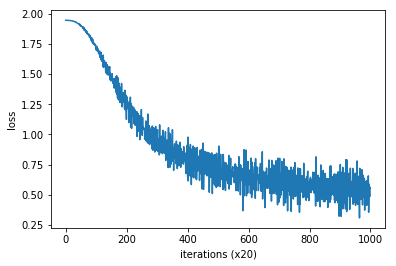

In [42]:
trainer.plot()

In [44]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.95485765  1.412862   -1.0217941   1.0618172   1.2536687 ]
say [-1.2102517  -0.02715805  1.2408004  -1.2167244  -0.12429754]
goodbye [ 1.0467042   0.40150106 -0.9073453   0.8858506   0.62997675]
and [-1.0185102  1.653024   1.0393983 -1.0264705  1.6828569]
i [ 1.0719883   0.42653477 -0.9278393   0.91068196  0.65510094]
hello [ 0.9388703  1.4064885 -1.0075836  1.0596321  1.2504405]
. [-1.0963067 -1.40362    1.0853074 -1.081416  -1.4235802]


## word2vecに関する補足

### CBOWモデルと確率

### skip-gramモデル

### カウントベース v.s. 推論ベース

## まとめ